In [79]:
import numpy as np
import pandas as pd
import pandas as pd
import re


import matplotlib.pyplot as plt



## Exploratory Data Analysis¶

In [3]:
# load in Amazon Fine Food Dataset
data_ori = pd.read_csv(r"./Reviews.csv")
data_ori.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
# remove reviews with scores of 3 which represents neutral sentiment
# the objective of this project is to predict whether a review is 
# negative(score 1 or 2) or positive (score 4 or 5)
data_ori = data_ori[data_ori.Score != 3]
# check the unique Score
data_ori.Score.unique()

array([5, 1, 4, 2])

In [5]:
"""
It is shown that there are duplicated identical reviews from 
the same customers for different products.
e.g the first two rows show the identical summaries'Green" K-cup packaging sacrifices flavor', 
texts 'Overall its just OK when considering the price.' sent at the same time from Breyton (thereby same userid), 
and the score are both negative.

Although the list of product name was not able to be accessed, ProductId=B005ZBZLT4 and ProductId=B007Y59HVM 
represents two products with the same brands but different flavors or quantities. Therefore, the inference 
is that the reviews with different ProductId, but same the other parameters represents the same product with 
different flavors or quantities.

As a result, the entries with different ProductId but the same other parameters were deleted. 
Redundancy in training data can cause bias to the model.
"""

pd.concat(v for i, v in data_ori.groupby("UserId") if len(v) > 1).head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
83317,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
180871,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
290947,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
455533,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
496893,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


In [6]:
"""
The approach used to eliminate entries of the same product with different ProductId is to firstly 
sort the ProductId in an ascending order. Then keep the first review as a representative and delete 
the remaining reviews. Doing sorting before elimination is to make sure noncontiguous entries of the 
same products would not have more than one representatives. 

"""

# Sorting data according to ProductId in ascending order

data_ori=data_ori.sort_values(
    'ProductId',
    axis=0,
    ascending = True, 
    inplace=False )
data_ori.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525814 entries, 150523 to 327600
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525798 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null int64
Time                      525814 non-null int64
Summary                   525789 non-null object
Text                      525814 non-null object
dtypes: int64(5), object(5)
memory usage: 44.1+ MB


In [7]:
# Deduplication of entries
data_ori=data_ori.drop_duplicates(
    subset=['UserId','ProfileName','Text'], 
    keep='first')
data_ori.shape

(363899, 10)

In [8]:
"""
Erroneous data of which HelpfulnessNumerator is greater than HelpfulnessDenominator were deleted. this is imposible in real life.

As shown below, entries of Id 64422 and 44737 are errorneous data where HelpfulnessNumerator is greater than HelpfulnessDenominator.

"""

data_ori[data_ori.HelpfulnessNumerator>data_ori.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
data_ori=data_ori[data_ori.HelpfulnessNumerator <= data_ori.HelpfulnessDenominator]

In [10]:
data_ori.shape

(363897, 10)

In [11]:
"""
Detect if there is any missing value in features that were used for training the data. If there is missingness
detected, print the number of missing value in each feature.

The reason why missing value must be replaced is because in the later stage, if missing value is not string, it would cause bug.
"""
data_ori.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    1
Text                       0
dtype: int64

In [12]:
# Show what does the value of missingness look like. The missing value is nan.
index_missing = data_ori.Summary.index[data_ori.Summary.isna()].tolist()
print('The missing values look like:')

for i,v in enumerate(index_missing):
    print(data_ori.Summary[v], end = ' ')

The missing values look like:
nan 

In [13]:
# Fill the missing value with string of blank space.
data_ori=data_ori.fillna(str(' '))

In [14]:
data_ori.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [15]:
import nltk

In [16]:
low_reviews = data_ori[data_ori.Score < 3].sort_values(by='Score')
low_reviews.loc['Time'] = pd.to_datetime(data_ori['Time'],unit = 's')
low_reviews.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150525,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,1,1129507200,awesome book poor size,This is one of the best children's books ever ...
363576,363577,B0024VFCRO,A2IOKYFBD8Y2HJ,Earl Grey,1,2,1,1271894400,Does not taste like the real thing,I bought this because I loved the Pongal made ...
273674,273675,B00250M2ZY,AC6NUFZ97BKMH,"Mary Lou ""irish_marylou""",4,7,1,1339286400,Bobs Sweet Stripes Soft Peppermint Balls & wha...,I was a big fan of these soft peppermint balls...


In [17]:
high_reviews = data_ori[data_ori.Score > 3].sort_values(by='Score')
high_reviews['Time'] = pd.to_datetime(data_ori['Time'],unit = 's')
high_reviews.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
270762,270763,B001EO623A,A14SOW889A4TAT,J. Tan,0,0,4,2012-04-04,Tasty!! Need more tender,Never try this brand before but saw it has a g...
442574,442575,B000FFPXDO,ABGH6P1RC1UDS,Shady,0,0,4,2006-12-26,OK for freeze dried.,"I like this one, although his split pea soup a..."
442563,442564,B000FFPXDO,AMPGRXQMO89X9,Faye L. Bowring,0,0,4,2011-09-05,Very tasty and convenient!,This is my first purchase of Dr. McDougall's p...


In [18]:
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stop_words = set(stopwords.words('english'))
# set of stopwords
print(stop_words)

{"you've", 'should', 'm', "shouldn't", 'themselves', 'which', 'll', 'we', 'other', 'both', 'ain', 'until', 'doing', 'any', 'ourselves', 'your', 'has', 'then', 'herself', 'ma', 'no', 'at', 'with', 'about', 'he', 'have', 'but', 'into', 'shouldn', 'are', "doesn't", 'same', "should've", "hadn't", 'some', 'isn', 'than', 'ours', "hasn't", 'below', 'over', 'too', 'itself', 'above', 'here', 'an', 'don', 'what', "needn't", 'had', 'o', 'on', 'doesn', 'weren', 'theirs', 'my', "you're", 'is', "isn't", 'against', 'being', 'before', 'does', 'very', 'most', 's', 'y', 'if', 'these', 'during', 'shan', 'you', "shan't", 'own', 'between', 'this', "it's", "you'll", 'aren', 'won', 'or', 'down', 'having', 'to', 'through', 'up', 'there', 'of', 'after', "don't", 'wouldn', 'me', 'i', 'where', 'all', "mustn't", 'not', 't', 're', 'by', 'further', 'mustn', 'd', 'such', 'their', 'and', "wouldn't", 'why', 'mightn', 'those', 'did', 'again', 'under', "weren't", 'am', "you'd", 'be', 'yourselves', 'will', 've', 'haven',

In [20]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/christina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [21]:
def clean_html(sentence):
    #function to clean the word of any html-tags
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner,' ',str(sentence))
    return cleantext

def clean_punc(sentence):
    #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',str(sentence))
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',str(cleaned))
    return  cleaned

def word_count(review_list):
#     str_list = str.replace('\n', '').lower().split(' ')
    count_dict = {}
    #    if the word appears, plus 1, otherwise add into dict
    for str in review_list:
        if str in count_dict.keys():
            count_dict[str] += 1
        else:
            count_dict[str] = 1
#     count_list= sorted(count_dict.iteritems(),key=lambda x:x[1],reverse=True)
#     count_list = list(count_dict)
    return count_dict

In [23]:
i = 0
final_string_neg=[]
s= ''
for review in low_reviews['Text'].values:
# iterate through 'Text' feature in the dataset
    filtered_sentence_neg=[]
    review = clean_html(review)
    review = clean_punc(review).lower()
#     print(review)
    for w in review.split():
        if((w.isalpha()) & (len(w)>2)):
            if(w.lower() not in stop_words):
                s=(w.lower()).encode('utf8')
                filtered_sentence_neg.append(s)
            else:
                continue
        else:
            continue 
#     print(filtered_sentence_neg)
    final_string_neg.append(filtered_sentence_neg)
    i+=1

In [24]:
review_list_neg = [item for sublist in final_string_neg for item in sublist]

review_list_neg[0:10]

[b'one',
 b'best',
 b'childrens',
 b'books',
 b'ever',
 b'written',
 b'mini',
 b'version',
 b'book',
 b'portrayed']

In [25]:
sorted_by_value_neg = sorted(word_count(review_list_neg).items(), reverse = True,key=lambda kv: kv[1])

In [26]:
sorted_by_score_neg = []
for t in sorted_by_value_neg:
    per = t[0],t[1]/len(review_list_neg)
    sorted_by_score_neg.append(per)

sorted_by_score_neg[0:10]
# sorted_by_per_neg = [(t[0],t[1]/len(review_list)) for t in sorted_by_value]

[(b'like', 0.012693397231142189),
 (b'product', 0.00990183619752484),
 (b'taste', 0.009443945360911088),
 (b'one', 0.007932522961503582),
 (b'would', 0.007634064867443367),
 (b'good', 0.006216176343667268),
 (b'coffee', 0.005937700486673761),
 (b'flavor', 0.005907939708063768),
 (b'dont', 0.005046152590314397),
 (b'get', 0.004677118935550483)]

In [27]:
sorted_by_score_neg = sorted_by_score_neg[0:1000]

In [29]:
tmp1 = []
for word, value in sorted_by_score_neg:
    tmp1.append(word_tokenize(word.decode('utf-8')))

pos_of_words = []
for w in tmp1:
    tmp2 = nltk.pos_tag(w)
    for item in tmp2:
        if item[1] == 'JJ':
            pos_of_words.append(tmp2)


In [32]:
neg_result =[]
for x in sorted_by_score_neg:
    for y in pos_of_words:
        if x[0].decode('utf-8') == y[0][0]:
            neg_result.append((x[0].decode('utf-8'),x[1]))

In [33]:
neg_result

[('good', 0.006216176343667268),
 ('much', 0.004007926570805781),
 ('bad', 0.003016892643093012),
 ('great', 0.002451012695523001),
 ('ive', 0.0024272040726350066),
 ('little', 0.002394467216164014),
 ('disappointed', 0.0021695607606684953),
 ('different', 0.0017235742354987417),
 ('old', 0.00171252023201503),
 ('many', 0.0016325912837481915),
 ('small', 0.001484212544678369),
 ('new', 0.0014633799996513737),
 ('hard', 0.0014195891396966696),
 ('hot', 0.0013141509526212655),
 ('organic', 0.0013103245667999807),
 ('whole', 0.0012979951013758408),
 ('free', 0.0012597312431629926),
 ('real', 0.0012350723123147125),
 ('natural', 0.001186604758578438),
 ('high', 0.0011751256011145836),
 ('last', 0.0011649219055911574),
 ('green', 0.0011610955197698726),
 ('big', 0.001067136490158323),
 ('local', 0.001056932794634897),
 ('regular', 0.0010033633931369093),
 ('strong', 0.0009893333117921984),
 ('several', 0.0009285362926317839),
 ('horrible', 0.0009238595988502135),
 ('terrible', 0.00088517058

In [34]:
i = 0
final_string_pos=[]
s=''
for review in high_reviews['Text'].values:
# iterate through 'Text' feature in the dataset
    filtered_sentence_pos=[]
    review = clean_html(review)
    review = clean_punc(review).lower()
#     print(review)
    for w in review.split():
        if((w.isalpha()) & (len(w)>2)):
            if(w.lower() not in stop_words):
                s=(w.lower()).encode('utf8')
                filtered_sentence_pos.append(s)
            else:
                continue
        else:
            continue 
#     print(filtered_sentenc_pos)
    final_string_pos.append(filtered_sentence_pos)
    i+=1

In [35]:
review_list_pos = [item for sublist in final_string_pos for item in sublist]

In [36]:
count_dict = word_count(review_list_pos)
sorted_by_value_pos = sorted(count_dict.items(), key=lambda kv: kv[1], reverse = True)
sorted_by_score_pos = [(t[0], t[1]/len(review_list_pos)) for t in sorted_by_value_pos]
sorted_by_score_pos[0:10]

[(b'like', 0.01063121082574851),
 (b'good', 0.009475792668990048),
 (b'great', 0.008892041511500321),
 (b'one', 0.007581428237017989),
 (b'taste', 0.007118432346322308),
 (b'product', 0.006453458382504349),
 (b'tea', 0.00640235965631273),
 (b'coffee', 0.006395799684707049),
 (b'flavor', 0.006377759762791427),
 (b'love', 0.006371717683680931)]

In [37]:
sorted_by_score_pos = sorted_by_score_pos[0:1000]

In [38]:
tmp1 = []
for word,value in sorted_by_score_pos:
    tmp1.append(word_tokenize(word.decode('utf-8')))


pos_of_words1 = []
for w in tmp1:
    tmp2 = nltk.pos_tag(w)
    for item in tmp2:
        if item[1] == 'JJ':
            pos_of_words1.append(tmp2)

In [40]:
pos_result = []
for x in sorted_by_score_pos:
    for y in pos_of_words1:
        if x[0].decode('utf-8') == y[0][0]:
            pos_result.append((x[0].decode('utf-8'),x[1]))

In [41]:
pos_result

[('good', 0.009475792668990048),
 ('great', 0.008892041511500321),
 ('much', 0.004113792720088774),
 ('little', 0.003974134377220464),
 ('ive', 0.0035326310250749734),
 ('delicious', 0.002426930547854302),
 ('nice', 0.0021508938479205234),
 ('many', 0.0019813703711631936),
 ('hot', 0.0019142169776208294),
 ('free', 0.001905499120618543),
 ('easy', 0.0017574681824114042),
 ('fresh', 0.0016759864298355794),
 ('healthy', 0.001603567795925498),
 ('organic', 0.0015899299602189511),
 ('different', 0.0014588168435211994),
 ('whole', 0.0014404316599421203),
 ('small', 0.001432490641682612),
 ('local', 0.0014030570848729126),
 ('happy', 0.0013721561659935215),
 ('hard', 0.001343413132510736),
 ('regular', 0.0013163100919293706),
 ('green', 0.0012801439326822618),
 ('high', 0.001240352525968856),
 ('old', 0.0012269736365099018),
 ('strong', 0.0012214494498945915),
 ('big', 0.0012037547896424263),
 ('natural', 0.0011940874630656335),
 ('last', 0.0011651717987511195),
 ('new', 0.001112605710489809

In [42]:
uniform_positive = []
uniform_negative = []
for x in pos_result:
    for y in neg_result:
        if x[0] == y[0]:
            uniform_positive.append(x)
            uniform_negative.append(y)

In [43]:
len(pos_result)

94

In [44]:
len(uniform_positive)

81

In [46]:
len(neg_result)

102

In [47]:
len(uniform_negative)

81

In [51]:
word_list_pos = []
value_list_pos = []
for t in uniform_positive:
    (w,v) = t
    word_list_pos.append(w)
    value_list_pos.append(v)

In [52]:
word_list_pos[0:5]

['good', 'great', 'much', 'little', 'ive']

In [53]:
value_list_pos[0:5]

[0.009475792668990048,
 0.008892041511500321,
 0.004113792720088774,
 0.003974134377220464,
 0.0035326310250749734]

In [54]:
word_list_neg = []
value_list_neg = []
for t in uniform_negative:
    (w,v) = t
    word_list_neg.append(w)
    value_list_neg.append(v)

In [55]:
word_list_neg[0:5]

['good', 'great', 'much', 'little', 'ive']

In [56]:
value_list_neg[0:5]

[0.006216176343667268,
 0.002451012695523001,
 0.004007926570805781,
 0.002394467216164014,
 0.0024272040726350066]

In [57]:
import matplotlib.pyplot as plt

In [61]:
x = list(range(len(word_list_pos[0:10])))
total_width,n = 0.8, 2.5
width = total_width / n

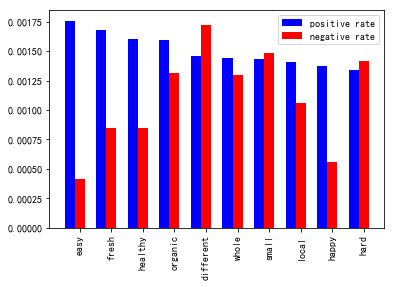

In [65]:
plt.bar(x,value_list_pos[10:20],width = width,label='positive rate',color = 'b')
for i in range(len(x)):
    x[i] = x[i]+width
plt.bar(x, value_list_neg[10:20], width=width, label='negative rate',tick_label = word_list_pos[10:20],fc = 'r')
plt.legend()
plt.xticks(rotation=90)
plt.show()

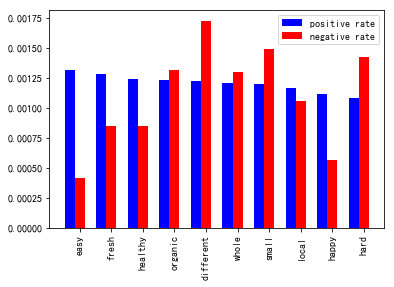

In [72]:
plt.bar(x, value_list_pos[20:30], width=width, label='positive rate',fc = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, value_list_neg[10:20], width=width, label='negative rate',tick_label = word_list_pos[10:20],fc = 'r')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [73]:
data_ori.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...


In [74]:
# So far, the index of the data is messy. The index must be reset for the following computation.
data_ori = data_ori.reset_index(drop=True)

In [77]:

"""
After some observation of the dataset, it is found that for some reviews the HelpnessNumerator is lower than half of the HelpnessDenominator.
In other words, more than half of customers do not think that review and score is representitive.

Therefore, for a review with positive score (4 or 5), if HelpnessNumerator is lower than half of the HelpnessDenominator, the score was reduced
by 1, and vice versa.
"""

start = time.time()
print("Start")

for i in range(0,len(data_ori)):
    if data_ori.loc[]

SyntaxError: unexpected EOF while parsing (<ipython-input-77-1e7a6a4fd58d>, line 12)

In [ ]:
    if original_dataset.loc[i,('HelpfulnessNumerator')] 
    < original_dataset.loc[i,('HelpfulnessDenominator')]/2 
    \and original_dataset.loc[i,('Score')] > 3:

